In [43]:
%matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy
nlp = spacy.load('en_core_web_sm')

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
import joblib

In [3]:

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
path = Path('..', 'data', 'bbc')
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]]).strip()
    doc_list.append([topic, heading, body])

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.head()

,topic,heading,body
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...


In [8]:
docs.sample(10)

,topic,heading,body
1818,sport,Soderling wins tense Milan final,Fifth seed Robin Soderling took the Milan Indo...
1381,sport,GB select Holmes for double bid,Kelly Holmes has been chosen for both the 800m...
1700,sport,Lions blow to World Cup winners,British and Irish Lions coach Clive Woodward s...
1280,politics,UK pledges Â£1bn to vaccine effort,UK Chancellor Gordon Brown has offered Â£960m ...
117,business,Ericsson sees earnings improve,Telecoms equipment supplier Ericsson has poste...
2200,tech,T-Mobile bets on 'pocket office',"T-Mobile has launched its latest ""pocket offic..."
1482,sport,FA decides not to punish Mourinho,The Football Association will take no action a...
870,entertainment,Super Size Me wins writers' award,Super Size Me director Morgan Spurlock has won...
935,politics,Lords wrong on detainees - Straw,Jack Straw has attacked the decision by Britai...
966,politics,Visa decision 'every 11 minutes',Visa processing staff are sometimes expected t...


In [11]:
docs.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})

,count
sport,22.96%
business,22.91%
politics,18.73%
tech,18.01%
entertainment,17.34%
bbc,0.04%


## Explore Corpus

In [19]:
word_count = docs.body.str.split().str.len().sum()
print(f'Total word count: {word_count:,d} | per article: {word_count/len(docs):,.0f}')

Total word count: 842,975 | per article: 379


In [58]:
token_count = Counter()
for i, doc in enumerate(docs.body.tolist(), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    token_count.update([t.strip() for t in doc.split() if t not in nlp.Defaults.stop_words])

500 1000 1500 2000 

In [59]:
tokens = pd.DataFrame(token_count.most_common(), columns=['token', 'count']).set_index('token')
tokens

,count
token,
said,4899
-,3182
Mr,2979
I,2234
people,1692
...,...
"""online",1
"universe""",1
"24hours,",1


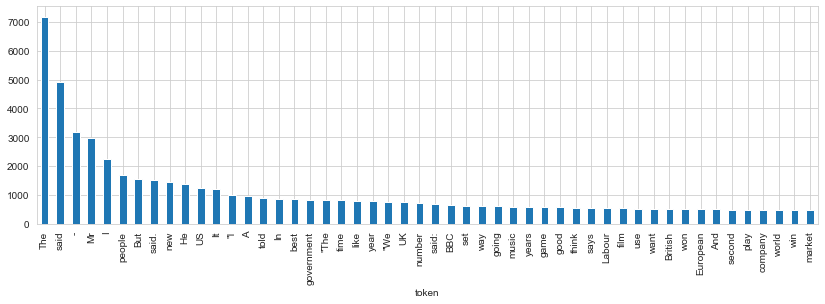

In [50]:
tokens['count'].head(50).plot(kind='bar',figsize=(14, 4))

In [60]:
# #to add as stop word
# nlp.Defaults.stop_words.add('The')
# nlp.vocab['btw'].is_stop = True
# nlp.vocab['btw'].is_stop = Fase # to remove

## Vectorizers

In [61]:
print(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be a sequence of items that
        can be of type string or byte.

    encoding : string, 'utf-8'

In [67]:
docs

,topic,heading,body
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...
...,...,...,...
2221,tech,BT program to beat dialler scams,BT is introducing two initiatives to help beat...
2222,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to ig...
2223,tech,Be careful how you code,A new European directive could put software wr...
2224,tech,US cyber security chief resigns,The man making sure US computer networks are s...


In [68]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                                    min_df=1,
                                    binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs.body)

In [69]:
m = binary_dtm.todense()

In [70]:
m

matrix([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

### most simmilar

In [71]:
pairwise_distances = pdist(m, metric='cosine')

In [72]:
closest = np.argmin(pairwise_distances)

In [73]:
rows, cols = np.triu_indices(n_docs)
rows[closest], cols[closest]

(6, 245)

In [74]:
docs.iloc[6]

topic                                               business
heading                     Jobs growth still slow in the US
body       The US created fewer jobs than expected in Jan...
Name: 6, dtype: object

In [75]:
docs.iloc[245]

topic                                               business
heading                     Ebbers 'aware' of WorldCom fraud
body       Former WorldCom boss Bernie Ebbers was directl...
Name: 245, dtype: object

In [76]:
pd.DataFrame(binary_dtm[[6, 245], :].todense())

,0,1,2,3,4,5,6,7,8,9,...,29276,29277,29278,29279,29280,29281,29282,29283,29284,29285
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
pd.DataFrame(binary_dtm[[6, 245], :].todense()).sum(0)

0        0
1        1
2        0
3        0
4        0
        ..
29281    0
29282    0
29283    0
29284    0
29285    0
Length: 29286, dtype: int64

In [78]:
pd.DataFrame(binary_dtm[[6, 245], :].todense()).sum(0).value_counts()

0    28983
1      265
2       38
dtype: int64

In [79]:
#38 common words

## Baseline document-term matrix¶


In [80]:

# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix

<2226x29286 sparse matrix of type '<class 'numpy.int64'>'
	with 445926 stored elements in Compressed Sparse Row format>

In [81]:
doc_term_matrix.shape

(2226, 29286)

In [92]:

# vectorizer keeps words
words = vectorizer.get_feature_names()
words[-10:]

['zooms',
 'zooropa',
 'zornotza',
 'zorro',
 'zubair',
 'zuluaga',
 'zurich',
 'zutons',
 'zvonareva',
 'zvyagintsev']

In [93]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.DataFrame.sparse.from_spmatrix(doc_term_matrix, columns=words)
doc_term_matrix_df.tail()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
2221,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2225,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head()

the    52580
to     24768
of     19933
and    18575
in     17555
dtype: int32

### TFiDF

In [103]:
print(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf for a term t of a document d
    in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is
    computed as idf(t) = log [ n / df(t) ] + 1 (if ``smooth_idf=False``), where
    n is the total number of documents in the document set and df(t) is the
    document frequency of t; the document frequency is the number of do

In [151]:
sample_docs = ['call you tomorrow', 
                'Call me a taxi', 
                'please call me... PLEASE!']

#### <font color=green> term frequency 

In [152]:
vectorizer = CountVectorizer()
tf_dtm = vectorizer.fit_transform(sample_docs)
tokens = vectorizer.get_feature_names()

In [157]:
term_frequency = pd.DataFrame(data=tf_dtm.todense(),columns=tokens)
term_frequency

,call,me,please,taxi,tomorrow,you
0,1,0,0,0,1,1
1,1,1,0,1,0,0
2,1,1,2,0,0,0


#### <font color=green> document frequency 

In [158]:
vectorizer = CountVectorizer(binary=True)
df_dtm = vectorizer.fit_transform(sample_docs).todense()
document_frequency = pd.DataFrame(data=df_dtm,columns=tokens)
document_frequency

,call,me,please,taxi,tomorrow,you
0,1,0,0,0,1,1
1,1,1,0,1,0,0
2,1,1,1,0,0,0


In [159]:
vectorizer = CountVectorizer(binary=True)
df_dtm = vectorizer.fit_transform(sample_docs).todense().sum(axis=0)
document_frequency = pd.DataFrame(data=df_dtm,columns=tokens)
document_frequency

,call,me,please,taxi,tomorrow,you
0,3,2,1,1,1,1


#### <font color=green> TF-IDF 

In [112]:
tfidf = pd.DataFrame(data=tf_dtm/df_dtm, columns=tokens)
print(tfidf)

   call   me  please  taxi  tomorrow  you
0  0.33 0.00    0.00  0.00      1.00 1.00
1  0.33 0.50    0.00  1.00      0.00 0.00
2  0.33 0.50    2.00  0.00      0.00 0.00


In [113]:
vect = TfidfVectorizer(smooth_idf=True, #add one to document frequency, as if an extra document contained every token in the vocabulary once to prevents zero divisions
                       norm='l2',            # squared weights sum to 1 by document
                       sublinear_tf=False,   # if True, use 1+log(tf)
                       binary=False)
print(pd.DataFrame(vect.fit_transform(sample_docs).todense(), 
             columns=vect.get_feature_names()))

   call   me  please  taxi  tomorrow  you
0  0.39 0.00    0.00  0.00      0.65 0.65
1  0.43 0.55    0.00  0.72      0.00 0.00
2  0.27 0.34    0.90  0.00      0.00 0.00


### TfIDF with new articles

In [160]:
tfidf = TfidfVectorizer(stop_words='english')
dtm_tfidf = tfidf.fit_transform(docs.body)
tokens = tfidf.get_feature_names()
dtm_tfidf.shape

(2226, 28991)

In [161]:
dtm_tfidf

<2226x28991 sparse matrix of type '<class 'numpy.float64'>'
	with 319109 stored elements in Compressed Sparse Row format>

In [163]:
pd.DataFrame({'tfidf': dtm_tfidf.todense().sum(axis=0).A1,'token': tokens})

,tfidf,token
0,0.30,00
1,21.00,000
2,0.07,0001
3,0.11,000bn
4,2.66,000m
...,...,...
28986,0.04,zuluaga
28987,1.02,zurich
28988,0.12,zutons
28989,0.31,zvonareva


In [140]:
token_freq = (pd.DataFrame({'tfidf': dtm_tfidf.sum(axis=0).A1,
                            'token': tokens})
              .sort_values('tfidf', ascending=False))

In [141]:
token_freq

,tfidf,token
22753,87.28,said
17644,58.23,mr
28832,41.99,year
19480,37.31,people
18053,34.20,new
...,...,...
16833,0.01,meanings
23798,0.01,siblings
16733,0.01,mcalmont
3440,0.01,bargaining


In [119]:
token_freq.head(10).append(token_freq.tail(10)).set_index('token')


,tfidf
token,
said,87.28
mr,58.23
year,41.99
people,37.31
new,34.20
film,29.73
government,28.80
world,27.04
time,26.36


## Summarizing news articles using TfIDF weights

In [144]:
article = docs.sample(1).squeeze()
article_id = article.name

In [145]:

print(f'Topic:\t{article.topic.capitalize()}\n\n{article.heading}\n')
print(article.body)

Topic:	Politics

Peers debate Crown succession law

Peers are debating proposals to change the rules governing the succession to the throne.  Labour peer Lord Dubs' Succession to the Crown Bill aims to end the right of male heirs to succeed to the crown even if they have an older sister. The private member's bill would also abolish the ban on heirs to the throne marrying Roman Catholics. The Fabian Society's Sundar Katwala said the change was "long overdue" and that he expected a "warm response". The political reform group's general secretary told BBC Radio 4's Today Programme there were some "very out-dated features" at the heart of Britain's constitution.  "In 1998 the government said in principle it supported the idea of ending gender discrimination and that it would consult on how to come forward with its own measures. "We hope they are warm towards it and don't say this is the wrong time." He pointed out that it was 30 years since the sex discrimination act and urged politicians o

In [147]:
article

topic                                               politics
heading                    Peers debate Crown succession law
body       Peers are debating proposals to change the rul...
Name: 1161, dtype: object

In [131]:
article_tfidf = dtm_tfidf[article_id].todense().A1
article_tokens = pd.Series(article_tfidf, index=tokens)
article_tokens.sort_values(ascending=False).head(20)

smith        0.41
vogts        0.36
scotland     0.23
ferguson     0.16
scottish     0.14
ibrox        0.14
hands        0.13
souness      0.13
1986         0.13
players      0.13
widely       0.12
experience   0.12
rangers      0.12
cup          0.11
manager      0.11
assistant    0.11
safe         0.10
alex         0.10
national     0.10
impressive   0.10
dtype: float64